# Compare results from two git branches
With this notebook, you can quickly compare the model results of two different git branches of STEMMUS_SCOPE.

To run this notebook, the latest release of [PyStemmusScope](https://github.com/EcoExtreML/STEMMUS_SCOPE_Processing) is required.

Additionally, you need to have a local clone of the `EcoExtreML/STEMMUS_SCOPE` github repository, as well as all required input data.

### Configuration
In the following cell, you configure the local setup. 

- Set the path to your config template (pointing to the right data directories).
- Specify what you use to run the model (Octave or Matlab), and which branches you would like to compare.
- Configure for which site you want to run the model, and for what start and end times.

In [1]:
# user must provide the correct path
path_to_config_template = "/media/bart/OS/STEMMUS_SCOPE_data/config_template.txt"
path_to_repository = "/home/bart/git/STEMMUS_SCOPE"
required_netcdf_variables = path_to_repository + "/utils/csv_to_nc/required_netcdf_variables.csv"

# Setup the runner: "Octave"/"Matlab", and the git branches here:
runner = "Octave"
main_branch = "main"
test_branch = "dynamic-lc-bart"

# Configure your desired site here:
model_location = "ZA-Kru"
model_start = "2001-01-01T00:00"
model_end = "2001-01-14T00:00"

Before continuing, run the following command to ensure that you can change between the two branches without any errors:

In [2]:
!cd $path_to_repository; git checkout $main_branch; git pull
!cd $path_to_repository; git checkout $test_branch; git pull

Switched to branch 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
Switched to branch 'dynamic-lc-bart'
Your branch is up to date with 'origin/dynamic-lc-bart'.
Already up to date.


### The rest of the notebook should not need any changes. Just do Run All 😃🚀
Once the models have been run, the bottom of this notebook will contain the output analysis.

In [3]:
from PyStemmusScope import StemmusScope
from PyStemmusScope import save
from pathlib import Path

if runner in ("Octave", "Matlab"):
    model_source = path_to_repository + "/src"
    model = StemmusScope(
        config_file=path_to_config_template, 
        model_src_path=model_source,
        interpreter=runner,
    )
else:
    raise ValueError("Unknown runner")

config_path = model.setup(
    Location=model_location,
    StartTime=model_start,
    EndTime=model_end,
)
print("Path to config: " + config_path)

Path to config: /media/bart/OS/STEMMUS_SCOPE_data/workdir/input/ZA-Kru_2023-05-26-1051/ZA-Kru_2023-05-26-1051_config.txt


In [4]:
!cd $path_to_repository; git checkout $main_branch; git pull

Switched to branch 'main'
Your branch is up to date with 'origin/main'.
Already up to date.


In [5]:
result = model.run()
print(result)
nc_file_main = save.to_netcdf(config_path, required_netcdf_variables)
nc_file_main = Path(nc_file_main).rename(
    str(nc_file_main).replace(".nc", "__main_run.nc")
)

Reading config from /media/bart/OS/STEMMUS_SCOPE_data/workdir/input/ZA-Kru_2023-05-26-1051/ZA-Kru_2023-05-26-1051_config.txt
The calculations start now
The calculations end now



In [6]:
!cd $path_to_repository; git checkout $test_branch; git pull

Switched to branch 'dynamic-lc-bart'
Your branch is up to date with 'origin/dynamic-lc-bart'.
Already up to date.


In [12]:
result = model.run()
nc_file_test = save.to_netcdf(config_path, required_netcdf_variables)
nc_file_test = Path(nc_file_test).rename(
    str(nc_file_test).replace(".nc", "__test_run.nc")
)

In [16]:
import xarray as xr
ds_main = xr.open_dataset(nc_file_main)
ds_test = xr.open_dataset(nc_file_test)

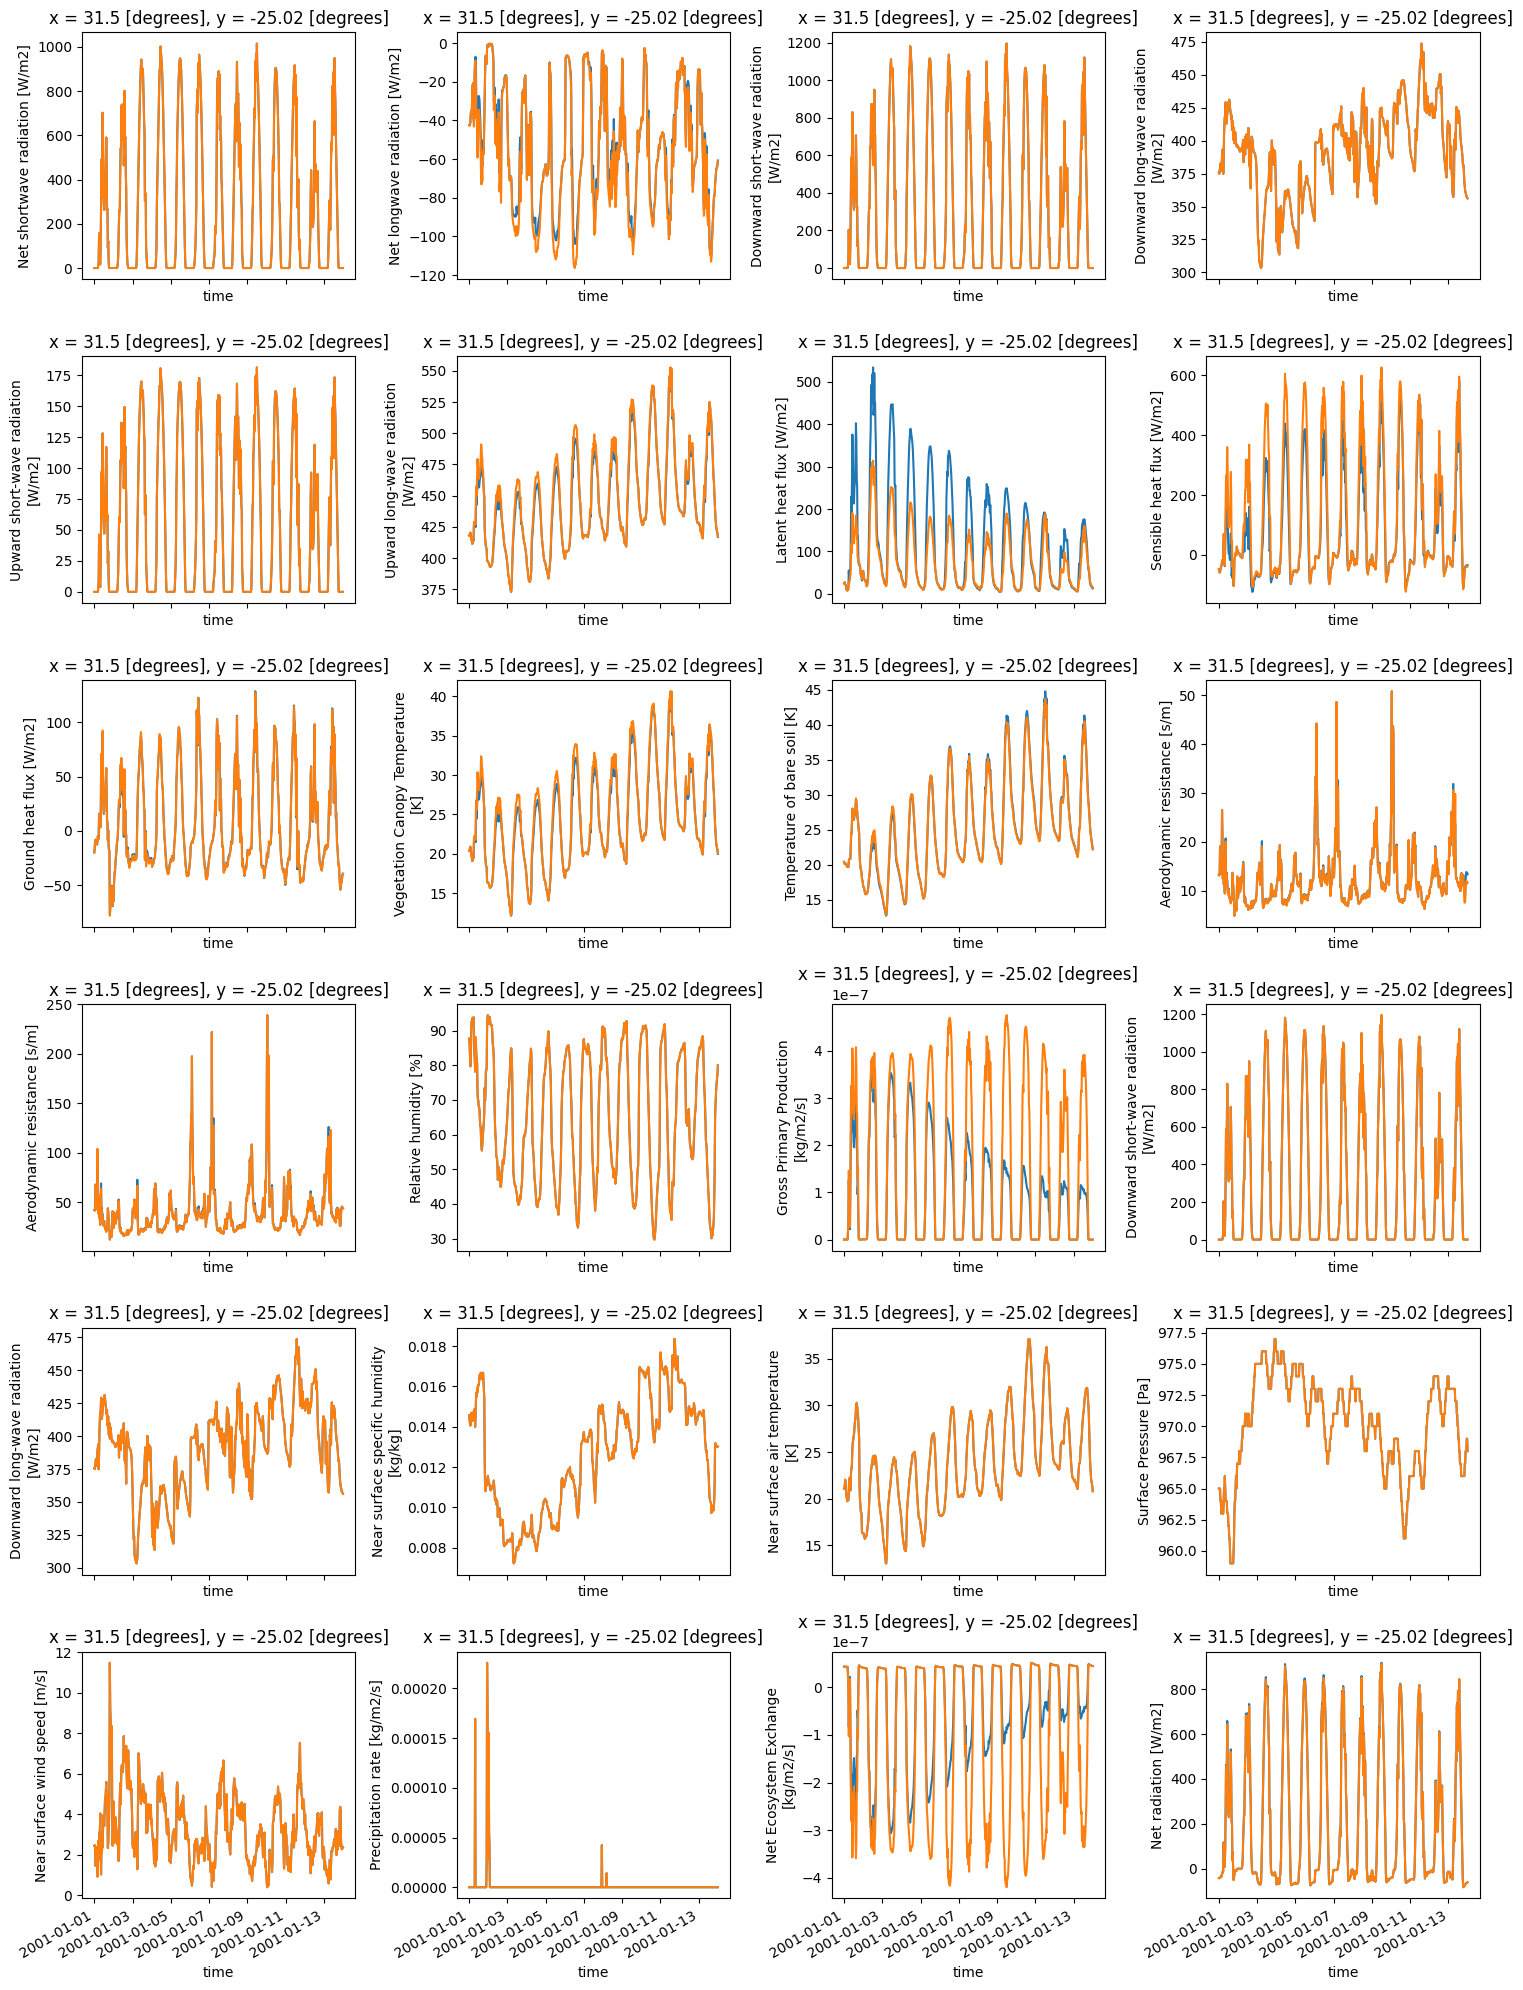

In [17]:
import numpy as np
import matplotlib.pyplot as plt

all_keys = list(ds_main.keys())
keys_3dvars = ("SoilTemp", "SoilMoist")
keys_2dvars = [key for key in all_keys if key not in keys_3dvars]

nplots = len(keys_2dvars)
ncols = 4 
nrows = np.ceil(nplots/ncols).astype(int)

fig, axes = plt.subplots(nrows, ncols, sharex=True, figsize=(15,20))
axes = axes.flatten()

for i, key in enumerate(keys_2dvars):
    ds_main[key].plot(ax=axes[i])
    ds_test[key].plot(ax=axes[i])

axes[0].legend(["main", "test"], loc="upper left")

plt.tight_layout()

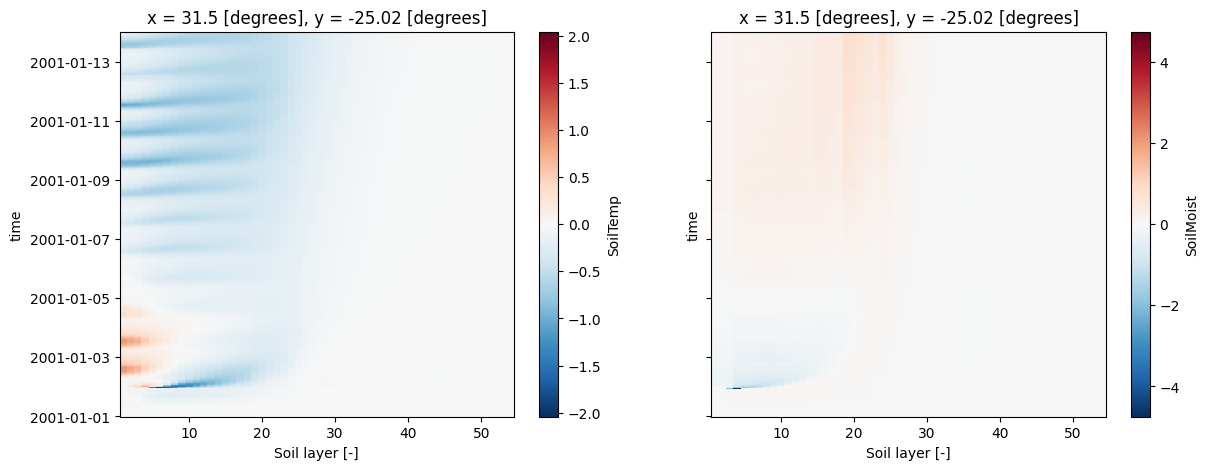

In [15]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(14,5))
for i, key in enumerate(keys_3dvars):
    (ds_test[key] - ds_main[key]).plot(ax=axes[i])

In [ ]:
for key in ds_main.keys():
    np.testing.assert_allclose(
        ds_main[key],
        ds_test[key],
        rtol=1e-4,
        atol=np.abs(ds_main[key]).mean().values / 1000  # to allow for a small difference when the variable's value crosses 0.
    )